## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 1. Camera Calibration

**Source code:** calibrate_camera.py

Camera calibration is done by loading the calibration images at __camera_cal/calibrate*.jpg__ and running grayscale versions through _cv2.findChessboardCorners()_. Corners are drawn on these images using _cv2.drawChessboardCorners()_ and saved as output to __camera_cal/corners*.jpg__.  objpoints and imgpoints are passed to _cv2.calibrateCamera()_ which returns the distortion coefficients needed to undistort the image.  Distortion coefficients are stored in a pickle file so that they can be re-used throughout the project.   _cv2.undistort()_ can now be used to undistort any image taken with this camera in the project using __Distortion__ class that loads camera calibration object from the pickle file.

In [ ]:
# Calibrate camera and undistort example chessboard images
from calibrate_camera import calibrate_camera
from distortion import Distortion
from image_helper import rgb_image, rgb_to_gray, sorter
import matplotlib.pyplot as plt
import glob

calibrate_camera()

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

# Make a list of calibration images
images = sorted(glob.glob('./camera_cal/calibration*.jpg'))

for i, filepath in enumerate(images[:5]):
    
    img = rgb_image(filepath)

    dst = distortion.undistort(img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Original image" +filepath)
    ax1.imshow(img)
    
    ax2.set_title("Undistorted image")
    ax2.imshow(dst)

    plt.show()

## 2. Undistort test images

**Source code:** transformation.py

Here are some examples of all __test_images/*.jpg__ undistorted using Distortion class that holds the camera calibration data, distortion coefficients, access and transformation methods from the pickle file on insantiatiation.

In [ ]:
# Undistort test images
from distortion import Distortion
from image_helper import rgb_image, bgr_to_rgb
import matplotlib.pyplot as plt
import glob
import cv2

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)
    undt = distortion.undistort(img)
    
    plt.imsave("./output_images/undistort_{:02d}.jpg" .format(i), bgr_to_rgb(undt))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Original image"+filepath)
    ax1.imshow(bgr_to_rgb(img))

    ax2.set_title("Undistorted image")
    ax2.imshow(bgr_to_rgb(undt))

    plt.show()

## 3. Gradient and Colour threshold transformations

__Source code:__ combined_thresholds.py

The code in this file applies multiple gradient and thresholding transformations to images.  

__Sobel gradient thesholding in X and Y directions__  
Using sobel gradient thresholding I was able to detect changes in horizontal and vertical directions.  

__Sobel gradient magnitude thresholding__  
This was not used in final version as it did not offer any additional clarity over X and Y gradient thresholding.

__Sobel gradient direction thresholding__  
This was not used in final version as it seemed to add a lot of additional noise in the image background.

__HLS - Saturation channel thresholding__  
After converting the RGB image to the HLS colorspace, the Saturation channel is good at detecting yellow lines.  

__RGB - Red channel thresholding__  
The red channel of the RGB image in BGR channel order is good at detecting white lines.  


After experimenting with values and different combinations, the thresholding techniques were combined using OR operators on __Grad-X, Grad-Y, Saturation__ and __Red channel__ transforms. 


In [ ]:
# Transform undistorted images via thresholding combinations
from distortion import Distortion
from image_helper import rgb_image, bgr_to_rgb
import matplotlib.pyplot as plt
import combined_thresholds
import glob

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)
    
    img = distortion.undistort(img)
    dst, gb = combined_thresholds.pipeline(img)
    
    plt.imsave("./output_images/threshold_{:02d}.jpg" .format(i), dst, cmap='gray')
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Undistorted image"+filepath)
    ax1.imshow(bgr_to_rgb(img))
    
    ax2.set_title("Grad-X and Saturation transforms on Green and Blue")
    ax2.imshow(gb)

    ax3.set_title("Combined threshold transforms")
    ax3.imshow(dst, cmap='gray')

    plt.show()

## 4. Perspective transformation

__Source code:__ birdseye.py

This file instantiates a BirdsEyeView object with methods to transform the perspective of any image to or from birdseye view using __cv2.warpPerspective()__ which are in turn derived from a manually-set set of to-and-from polygon points transformed using __cv2.getPerspectiveTransform()__ using the initial straight line view of the road __./test_images/
straight_lines1.jpg__.  


In [ ]:
# Transform undistorted images with combined thresholds plus birds-eye combinations
from distortion import Distortion
from image_helper import rgb_image, bgr_to_rgb
from birdseye import BirdsEyeView
import matplotlib.pyplot as plt
import combined_thresholds
import glob
import cv2

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)

    birdseye = BirdsEyeView()
    img = distortion.undistort(img)
    bev = birdseye.transform_to_birdseye(img)
    thr, gb = combined_thresholds.pipeline(bev)
    
    plt.imsave("./output_images/birdseye_threshold_{:02d}.jpg" .format(i), thr, cmap='gray')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Birds-eye image"+filepath)
    ax1.imshow(bgr_to_rgb(bev))

    ax2.set_title("Birds-eye + Thresholded image")
    ax2.imshow(thr, cmap='gray')

    plt.show()

## 5. Find lane lines

__Source code:__ detect.py

Lane line detection is done using the sliding windows technique. The sum of all the line points detected in the thresholding phase is taken for the bottom half of the image which gives approximate location of where the two lane lines are. Using this approximation, we then find all the nonzero values inside a window, and store those points as points for the lane line. We slide the window up, and repeat finding nonzero values. When the sliding window reaches the top of the image, we fit a parabola to the points that were detected. This polynomial can be used to calculate the lane line values at any point.

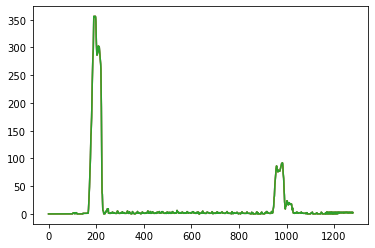

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2

# Histogram Peaks
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('./output_images/birdseye_threshold_00.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram =  np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

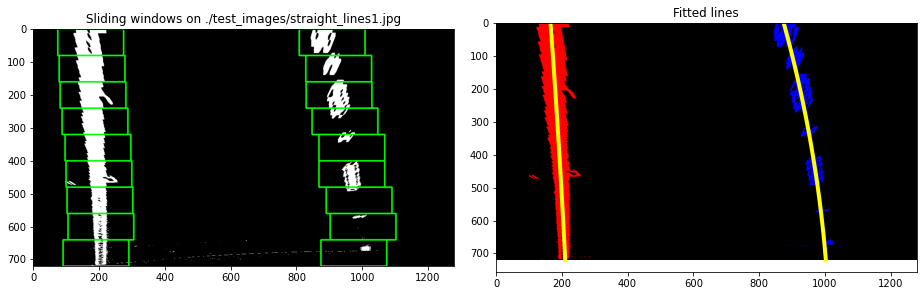

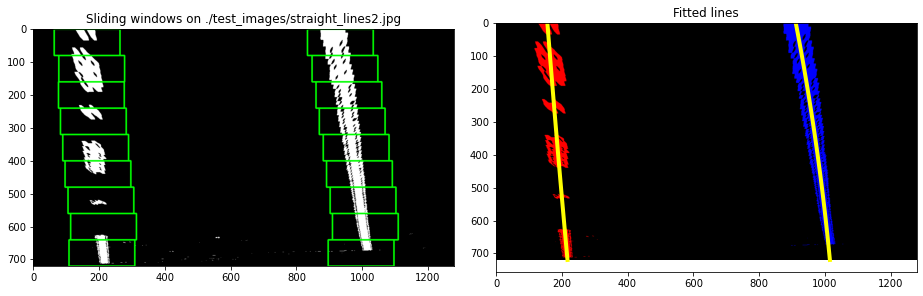

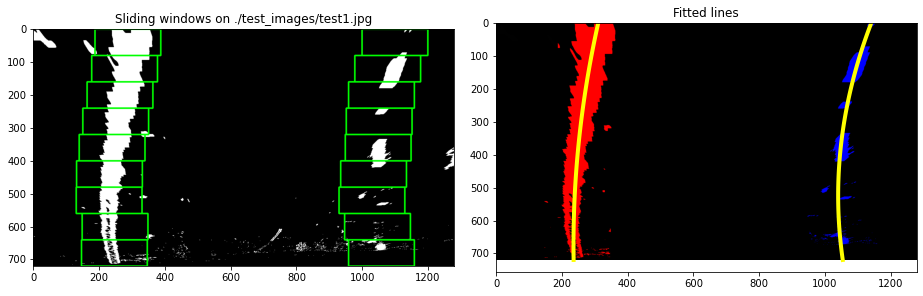

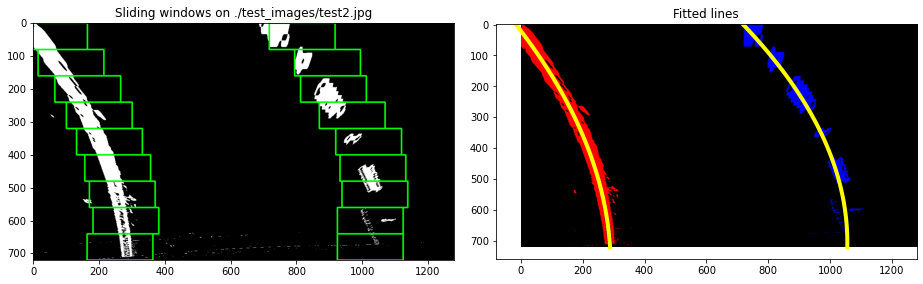

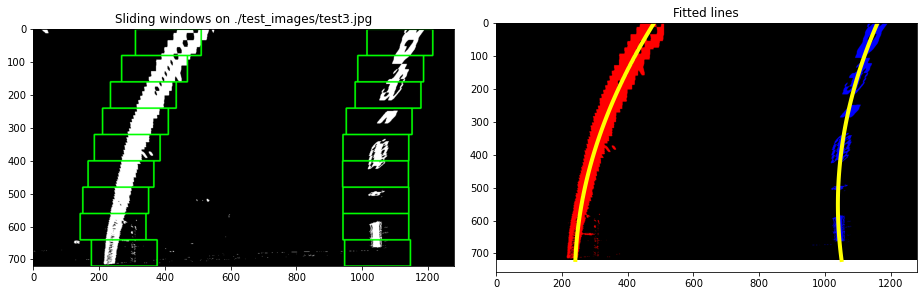

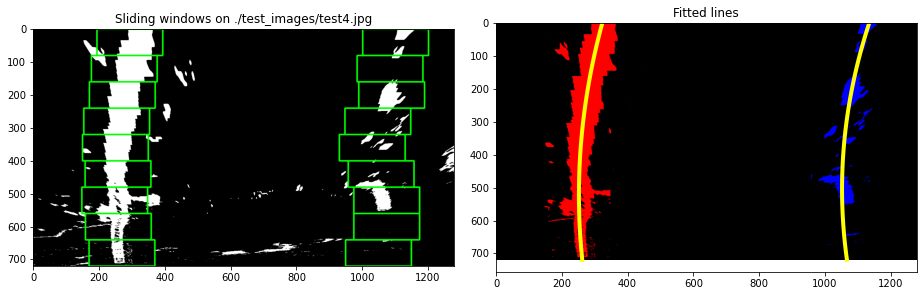

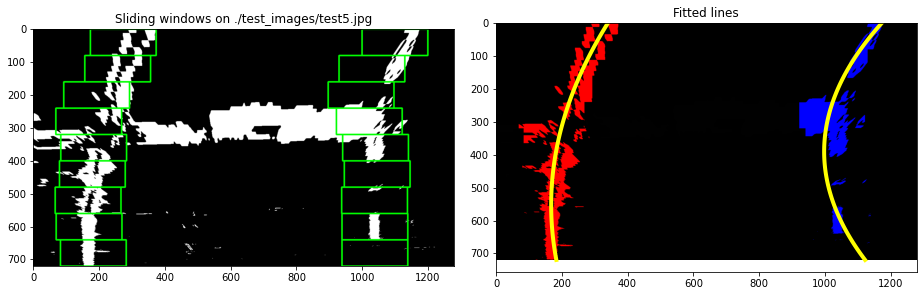

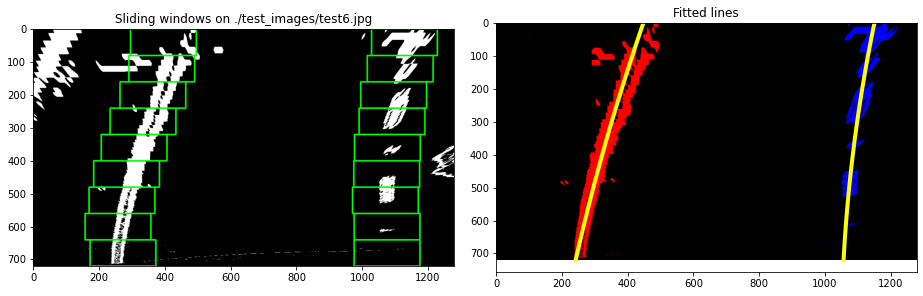

In [3]:
# Fit sliding windows to lane lines and find lines of best fit
from distortion import Distortion
from image_helper import rgb_image
from birdseye import BirdsEyeView
from detect import detect_lane_lines
import combined_thresholds

distortion = Distortion("./camera_cal/wide_dist_pickle.p")
birdseye = BirdsEyeView()

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)
    img = distortion.undistort(img)
    img, gb = combined_thresholds.pipeline(img)
    img = birdseye.transform_to_birdseye(img)
    lanes, win_img, lanes_img = detect_lane_lines(img)
      
    plt.imsave("./output_images/windows_{:02d}.jpg" .format(i), win_img)
    plt.imsave("./output_images/lanes_{:02d}.jpg" .format(i), lanes_img)
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Sliding windows on "+filepath)
    ax1.imshow(win_img)

    ax2.set_title("Fitted lines")
    ax2.imshow(lanes_img)
    
    # Left lane
    left_p = np.poly1d(lanes.left.pixels.fit)
    left_xp = np.linspace(0, 720, 100)
    # left_xp 
    ax2.plot(left_p(left_xp), left_xp, linewidth=4, color='yellow')

    # Right lane
    right_p = np.poly1d(lanes.right.pixels.fit)
    right_xp = np.linspace(0, 720, 100)
    # right_xp 
    ax2.plot(right_p(right_xp), right_xp, linewidth=4, color='yellow')

    plt.show()

## 6. Determine lane curvature and vehicle position

__Source code:__ lane.py, lanes.py  

__Lane curvature__  
Lane curvature is determined using the following curvature formula  

fit = np.polyfit(xs, ys) # using the xs and ys found during detection  
p   = np.poly1d(fit)     # polynomial helper function  
p1  = np.polyder(p)      # first derivative of our polynomial  
p2  = np.polyder(p, 2)   # second derivative of our polynomial  

y is the point at which you'd like to find the curvature   
__((1 + (p1(y)*2))*1.5) / np.absolute(p2(y))__  
These calculations are performed inside lane.py.  

In the examples below, you can see the image with a straight lane has a very large curvature radius, whereas the image with the lane that is curving rightward has a smaller curvature radius.  

__Vehicle offset position__  
Assuming the camera is mounted in the center of the car, the vehicle offset position can be calculated by measuring the distance from the center of the lane to the center of the image.

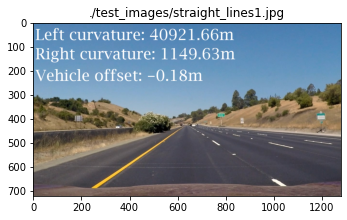

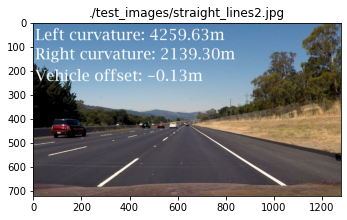

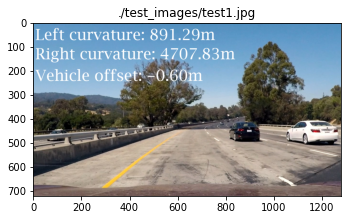

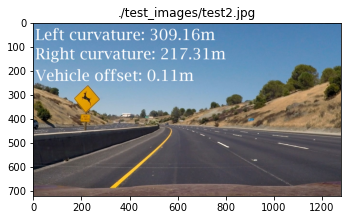

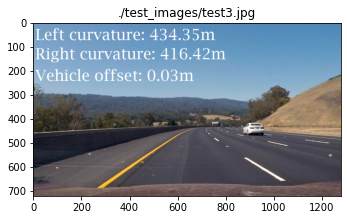

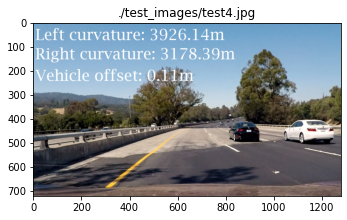

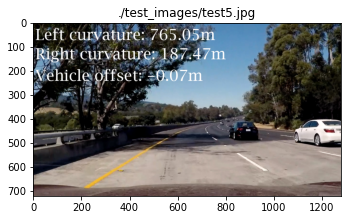

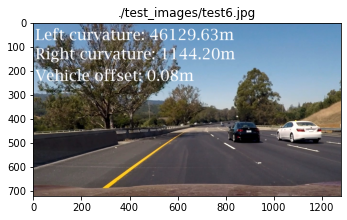

In [4]:
from distortion import Distortion
from image_helper import rgb_image
from birdseye import BirdsEyeView
from detect import detect_lane_lines
from overlay import overlay_text
from distortion import Distortion
import combined_thresholds
import matplotlib.pyplot as plt
import numpy as np
import cv2

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

images = sorted(glob.glob('./test_images/*.jpg'))

def overlay_information(img, lanes):
    height, width, _ = img.shape
    
    left_curvature = lanes.left.meters.curvature(height)
    right_curvature = lanes.right.meters.curvature(height)
    distance_from_center = lanes.distance_from_center(center=(width/2, height))
    
    img = overlay_text(img, "Left curvature: {0:.2f}m".format(left_curvature), pos=(10, 10))
    img = overlay_text(img, "Right curvature: {0:.2f}m".format(right_curvature), pos=(10, 90))
    img = overlay_text(img, "Vehicle offset: {0:.2f}m".format(distance_from_center), pos=(10, 180))
    return img

def load_image_and_overlay_information(filepath, ax):
    img = rgb_image(filepath)
    dst = distortion.undistort(img)
    dst = birdseye.transform_to_birdseye(dst)
    dst, gb = combined_thresholds.pipeline(dst)
    lanes, win, lanes_img = detect_lane_lines(dst)
    
    img = overlay_information(img, lanes)
    
    ax.set_title(filepath)
    ax.imshow(img)
    
    return img

birdseye = BirdsEyeView()

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)

    f, (ax1) = plt.subplots(1, 1, figsize=(5, 3))
    f.tight_layout()

    overlay_img = load_image_and_overlay_information(filepath, ax1)
    plt.imsave("./output_images/overlay_{:02d}.jpg" .format(i), overlay_img)

plt.show()

## 7. Overlay on road

__Source code:__ pipeline.py

The pipeline combines all the steps described above and performs them through a simple interface. 

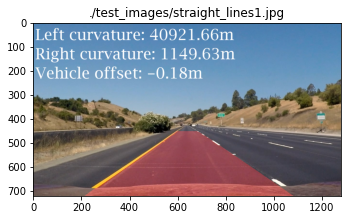

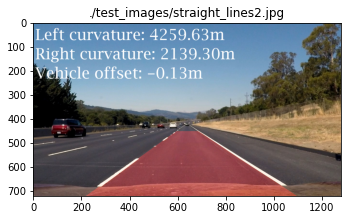

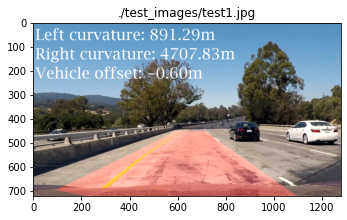

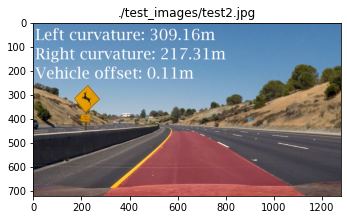

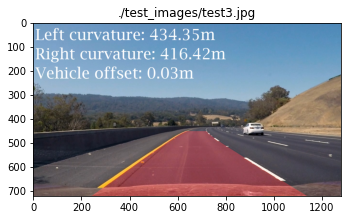

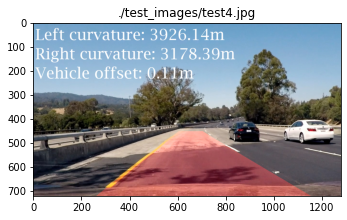

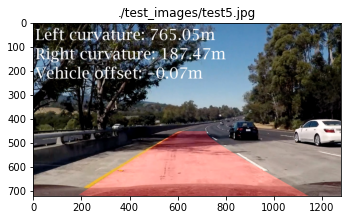

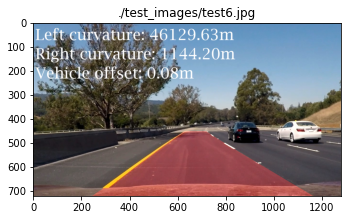

In [1]:
from pipeline import Pipeline
import matplotlib.pyplot as plt
from distortion import Distortion
from image_helper import rgb_image
import glob
import cv2

images = sorted(glob.glob('./test_images/*.jpg'))

def process_image_pipeline(filepath, ax):
    pipeline = Pipeline()
    img = rgb_image(filepath)
    out = pipeline.process_image_pipeline(img)
    ax.set_title(filepath)
    ax.imshow(out)
    
    return out
    
for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)

    f, (ax1) = plt.subplots(1, 1, figsize=(5, 3))
    f.tight_layout()

    pipe_out = process_image_pipeline(filepath, ax1)
    plt.imsave("./output_images/overlay_{:02d}.jpg" .format(i), pipe_out)

plt.show();

## 9. Pipeline on video

Using the MoviePY library, each image in the video is passed through pipeline.process_image_pipeline() and then combined to produce a new video.

In [8]:
from moviepy.editor import VideoFileClip
from pipeline import Pipeline
import matplotlib.pyplot as plt

pipeline = Pipeline()

def process_video_pipeline(clip):
    #white_clip = clip.fl_image(pipeline.process_image_pipeline).subclip(0,5) #NOTE: this function expects color images!!
    white_clip = clip.fl_image(pipeline.process_image_pipeline)
    white_clip.write_videofile(video_output, audio=False)
    
#clip1 = VideoFileClip('project_video.mp4')
#video_output = './output_videos/ALL_project_video.mp4'
#clip2 = VideoFileClip('challenge_video.mp4')
#video_output = './output_videos/ALL_challenge_video.mp4'
clip3 = VideoFileClip('harder_challenge_video.mp4')
video_output = './output_videos/ALL_harder_challenge_video.mp4'
    
process_video_pipeline(clip3)
    

                                                                 
t:   0%|          | 1/1199 [03:43<74:26:21, 223.69s/it, now=None]
                                                                 A
t:   0%|          | 1/1199 [00:10<3:32:21, 10.64s/it, now=None]

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_videos/ALL_project_video.mp4.
Moviepy - Writing video ./output_videos/ALL_project_video.mp4



ValueError: not enough values to unpack (expected 3, got 2)